In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mspatches
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import math
import random
import json
%matplotlib inline
# from tqdm import tqdm

try:
    from google.colab import drive

    drive.mount('/content/gdrive')

    %tensorflow_version 1.x

    colab_running = True
except:
    print("Warning: running in localhost")

    colab_running = False

import tensorflow as tf #import the tensorflow library
from tensorflow.keras import datasets, layers, models #import the keras library from tensorflow
from tensorflow import keras

In [3]:
def load_weights_and_biases(x_train, epochs, loss_function): 
    
    weights_trained = np.load("Toy_" + str(x_train.shape[1]) + "d_epochs_" + str(epochs) + "_loss_" + loss_function + "_Weights.npy", allow_pickle=True).tolist()
    for j in range(len(weights_trained)):
        weights_trained[j] = tf.Variable(weights_trained[j])
    bias_trained = np.load("Toy_" + str(x_train.shape[1]) + "d_epochs_" + str(epochs) + "_loss_" + loss_function + "_Bias.npy", allow_pickle=True).tolist()
    for j in range(len(bias_trained)):
        bias_trained[j] = tf.Variable(bias_trained[j])
        
    return weights_trained, bias_trained

In [4]:
def Toy_NN(input_x, weights, biases):
    
    dens1 = tf.add(tf.matmul(input_x, weights[0]), biases[0])
    dens2 = tf.nn.relu(dens1)
    dens3 = tf.add(tf.matmul(dens2, weights[1]), biases[1])
    
    return dens3

In [5]:
def generate_n_dim_data(dim):
    theta = np.random.uniform(0, 2*np.pi, size=(2000))
    
    x1 = np.array([np.array([np.cos(theta[i])*3, np.sin(theta[i])*3]) for i in range(len(theta))])
    while x1.shape[len(x1.shape)-1] != dim:
      x1 = np.concatenate((x1, np.zeros((x1.shape[0], 1))), axis=1)
    y1 = np.concatenate((np.ones((2000,1)),np.zeros((2000,1))), axis=1)
    
    theta = np.random.uniform(0, 2*np.pi, size=(2000))
    
    x2 = np.array([np.array([np.cos(theta[i])*1, np.sin(theta[i])*1]) for i in range(len(theta))])
    while x2.shape[len(x2.shape)-1] != dim:
      x2 = np.concatenate((x2, np.zeros((x2.shape[0], 1))), axis=1)
    y2 = np.concatenate((np.zeros((2000,1)),np.ones((2000,1))), axis=1)
    
    x_train = np.concatenate((x1,x2), axis=0)
    y_train = np.concatenate((y1,y2), axis=0)
    shuffle = np.concatenate((x_train, y_train), axis=1)
    np.random.shuffle(shuffle)
    
    x_train = shuffle[2000:,:dim]
    x_test = shuffle[:2000,:dim]
    
    y_train = shuffle[2000:,-2:]
    y_test = shuffle[:2000,-2:]
    
    return x_train, y_train, x_test, y_test

# Training model

In [11]:
def train_distilled_temperature(x_train, y_train, x_test=None, y_test=None, epochs=250, loss_function="CCE", print_loss=True):
    
    weights = [tf.Variable(tf.random_normal([x_train.shape[1], 100], stddev=0.1)),
          tf.Variable(tf.random_normal([100, y_train.shape[1]], stddev=0.1))]

    biases = [tf.Variable(tf.random_normal([100], stddev=0.1)),
          tf.Variable(tf.random_normal([y_train.shape[1]], stddev=0.1))]

    x = tf.placeholder(tf.float32, shape=(None, x_train.shape[1]))
    y = tf.placeholder(tf.float32, shape=(None, y_train.shape[1]))

    logit = Toy_NN(x, weights, biases)

    prediction = tf.nn.softmax(logit)

    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logit))
    
    lr = 0.1
    train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss_op)

    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    batch_size = 50

    model_weights_trained = "Toy_" + str(x_train.shape[1]) + "d_epochs_" + str(epochs) + "_loss_" + loss_function + "_Weights"
    model_bias_trained = "Toy_" + str(x_train.shape[1]) + "d_epochs_" + str(epochs) + "_loss_" + loss_function + "_Bias"

    acc_train_list = list()
    acc_test_list = list()
    loss_train_list = list()
    loss_test_list = list()

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        # print(sess.run(weights['wc1']))

        for epoch in range(epochs):

            if epoch % 100 == 0 and epoch != 0:
                lr = lr/10

            for j in range(int(len(x_train)//batch_size)):
                
                image_batch = x_train[j*batch_size : min((j+1)*batch_size, len(x_train))]
                
                label_batch = y_train[j*batch_size : min((j+1)*batch_size, len(y_train))]

                # print(sess.run(loss_op, feed_dict={x: image_batch, y: label_batch}))

                sess.run(train_op, feed_dict={x: image_batch, y: label_batch})

            # print(sess.run(weights['wc1']))

            acc_train = 0
            loss_train = 0

            for j in range(10):

                image_batch = x_train[j*len(x_train)//10 : min((j+1)*len(x_train)//10, len(x_train))]
                label_batch = y_train[j*len(y_train)//10 : min((j+1)*len(y_train)//10, len(y_train))]

                loss_train += sess.run(loss_op, feed_dict={x: image_batch, y: label_batch})
                acc_train += sess.run(accuracy, feed_dict={x: image_batch, y: label_batch})
            
            loss_test = sess.run(loss_op, feed_dict={x: x_test, y: y_test})
            acc_test = sess.run(accuracy, feed_dict={x: x_test, y: y_test})

            acc_train_list.append(acc_train/10)
            acc_test_list.append(acc_test)
            loss_train_list.append(loss_train/10)
            loss_test_list.append(loss_test)
            
            if print_loss == True:
                
                print("EPOCH: " + str(epoch+1))

                print(" train loss: " + str(loss_train/10) + " train acc: " + str(acc_train/10) + " test loss: " + str(loss_test) + " test acc: " + str(acc_test))

        weights_after_train = sess.run(weights)
        biases_after_train = sess.run(biases)
        
    np.save(model_weights_trained + ".npy", weights_after_train)
    np.save(model_bias_trained + ".npy", biases_after_train)
    
    return acc_train_list, acc_test_list, loss_train_list, loss_test_list
    

In [12]:
def plot_after_training(acc_train, acc_test, loss_train, loss_test):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(acc_train)
    plt.plot(acc_test)
    plt.legend(['Train', 'Test'])
    plt.title("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.legend(['Train', 'Test'])
    plt.title("Loss")
    plt.show()

## 3-dimensional Input Space

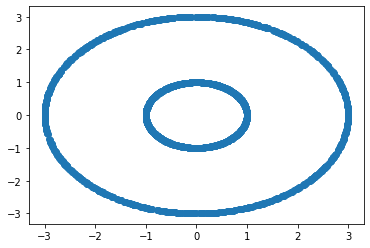

In [13]:
x_train, y_train, x_test, y_test = generate_n_dim_data(3)
plt.scatter(x_train[:,0], x_train[:,1])
plt.show()

In [ ]:
for i in range(20):
    acc_train, acc_test, loss_train, loss_test = train_distilled_temperature(x_train, y_train, x_test, y_test, 250, "CCE_%i"%i, print_loss=False)
    plot_after_training(acc_train, acc_test, loss_train, loss_test)

## 10-dimensional Input Space

In [21]:
x_train, y_train, x_test, y_test = generate_n_dim_data(10)

In [ ]:
for i in range(20):
    acc_train, acc_test, loss_train, loss_test = train_distilled_temperature(x_train, y_train, x_test, y_test, 250, "CCE_%i"%i, print_loss=False)
    plot_after_training(acc_train, acc_test, loss_train, loss_test)

## 50-dimensional Input Space

In [24]:
x_train, y_train, x_test, y_test = generate_n_dim_data(50)

In [ ]:
for i in range(20):
    acc_train, acc_test, loss_train, loss_test = train_distilled_temperature(x_train, y_train, x_test, y_test, 250, "CCE_%i"%i, print_loss=False)
    plot_after_training(acc_train, acc_test, loss_train, loss_test)

## 500-dimensional Input Space

In [27]:
x_train, y_train, x_test, y_test = generate_n_dim_data(500)

In [ ]:
for i in range(20):
    acc_train, acc_test, loss_train, loss_test = train_distilled_temperature(x_train, y_train, x_test, y_test, 250, "CCE_%i"%i, print_loss=False)
    plot_after_training(acc_train, acc_test, loss_train, loss_test)

# Pertubation Angle

In [16]:
def gradient_visualization(x_input, y_input, epochs=500, loss_function="CCE"):

    weights_trained, bias_trained = load_weights_and_biases(x_input, epochs, loss_function)

    x = tf.placeholder(tf.float32, shape=(None, x_input.shape[1]))
    y = tf.placeholder(tf.float32, shape=(None, y_input.shape[1]))

    logit = Toy_NN(x, weights_trained, bias_trained)
    prediction = tf.nn.softmax(logit)

    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=prediction))

    gradients = tf.gradients(loss_op, x)

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        if len(x_input.shape) < 2:

            gradient = sess.run(gradients, feed_dict={x:x_input.reshape(1, x_input.shape[0]), y:y_input.reshape(1, y_input.shape[0])})

        else:

            gradient = sess.run(gradients, feed_dict={x:x_input, y:y_input})

    return gradient

In [17]:
def angle_visualization_grad_proj(dim, manifold_dim, norm="INF", perturbation=None, epochs=500, loss_function="CCE"):

    theta = angle_calculation_grad_proj(dim, manifold_dim, norm, perturbation, epochs, loss_function)

    fig = plt.figure(figsize=(12, 6))

    plt.title("Angle Visualization", fontsize=15)
    plt.subplot(1,2,1)
    plt.hist((theta[:1000]/math.pi)*180, bins=50, range=(0, 180), rwidth=0.9)
    plt.xlabel("$\phi$", fontsize=15)
    plt.axis([0, 180, 0, 1000])
    plt.subplot(1,2,2)
    plt.hist((theta[1000:]/math.pi)*180, bins=50, range=(0, 180), rwidth=0.9)
    plt.xlabel("$\phi$", fontsize=15)
    plt.axis([0, 180, 0, 1000])
    plt.show()

In [18]:
def angle_calculation_grad_proj(dim, manifold_dim, norm="INF", perturbation=None, epochs=500, loss_function="CCE"):
    x_manifold, y_manifold = data_manifold(dim)
    if perturbation == None:
        gradients = gradient_visualization(x_manifold, y_manifold, epochs, loss_function)
    else:
        gradients = perturbation

    if norm == "INF":
        gradients = np.sign(gradients)
    elif norm == 2:
        gradients = gradients/np.sqrt(np.maximum(1e-20, np.sum(np.square(gradients))))
    else:
        print("Implemented only norms 2 and $\infty$")

    normal_space_dim = range(dim)
    normal_space_dim = np.delete(normal_space_dim, manifold_dim)

    np.asarray(gradients[0]).shape

    grad_proj = np.zeros(np.asarray(gradients[0]).shape)
    grad_proj[:, normal_space_dim] =  np.asarray(gradients[0])[:, normal_space_dim]

    dot_prod = list()
    for j in range(len(grad_proj)):
        dot_prod.append(np.sum(gradients[0][j]*grad_proj[j]))

    cos_theta = dot_prod/(np.sqrt(np.sum(np.square(gradients[0]), axis=1))*np.sqrt(np.sum(np.square(grad_proj), axis=1)))
    theta = np.arccos(np.clip(cos_theta, -1, 1))

    return theta

In [19]:
def data_manifold(dim):

    theta1 = np.linspace(0, 2*np.pi, 1000)
    theta2 = np.linspace(0, 2*np.pi, 1000)

    x1 = np.array([np.array([np.cos(theta1[i])*3, np.sin(theta1[i])*3]) for i in range(len(theta1))])
    while x1.shape[len(x1.shape)-1] != dim:
      x1 = np.concatenate((x1, np.zeros((x1.shape[0], 1))), axis=1)
    y1 = np.concatenate((np.ones((1000,1)),np.zeros((1000,1))), axis=1)

    x2 = np.array([np.array([np.cos(theta1[i])*1, np.sin(theta1[i])*1]) for i in range(len(theta1))])
    while x2.shape[len(x2.shape)-1] != dim:
      x2 = np.concatenate((x2, np.zeros((x2.shape[0], 1))), axis=1)
    y2 = np.concatenate((np.zeros((1000,1)),np.ones((1000,1))), axis=1)

    x_manifold = np.concatenate((x1,x2), axis=0)
    y_manifold = np.concatenate((y1,y2), axis=0)

    return x_manifold, y_manifold

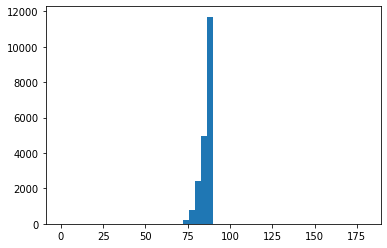

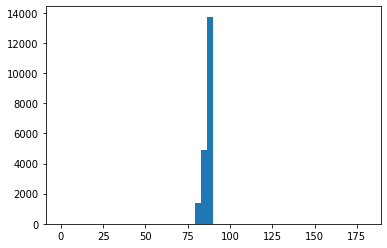

In [20]:
theta_list = list()
for i in range(20):
    theta_list.append(angle_calculation_grad_proj(3, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i)))
#     angle_visualization_grad_proj(3, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i+1))
    

plt.hist((np.asarray(theta_list[:len(theta_list)//2]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()

plt.hist((np.asarray(theta_list[len(theta_list)//2:]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()


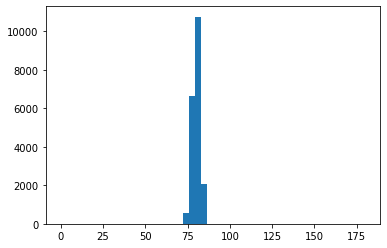

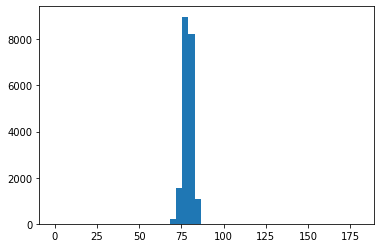

In [23]:
theta_list = list()
for i in range(20):
    theta_list.append(angle_calculation_grad_proj(10, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i)))
#     angle_visualization_grad_proj(3, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i+1))
    

plt.hist((np.asarray(theta_list[:len(theta_list)//2]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()

plt.hist((np.asarray(theta_list[len(theta_list)//2:]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()


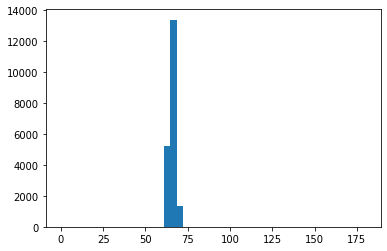

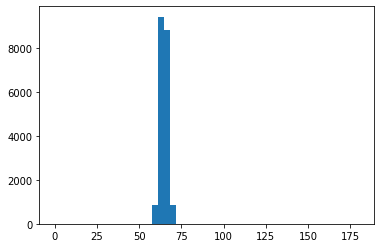

In [26]:
theta_list = list()
for i in range(20):
    theta_list.append(angle_calculation_grad_proj(50, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i)))
#     angle_visualization_grad_proj(3, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i+1))
    

plt.hist((np.asarray(theta_list[:len(theta_list)//2]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()

plt.hist((np.asarray(theta_list[len(theta_list)//2:]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()


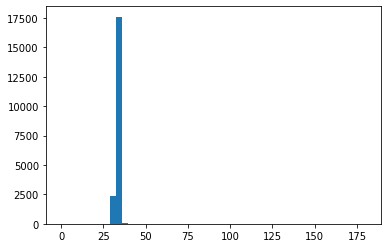

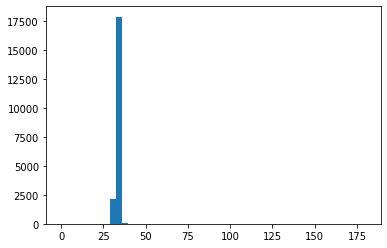

In [30]:
theta_list = list()
for i in range(20):
    theta_list.append(angle_calculation_grad_proj(500, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i)))
#     angle_visualization_grad_proj(3, [0,1], norm=2, epochs=250, loss_function="CCE_" + str(i+1))
    

plt.hist((np.asarray(theta_list[:len(theta_list)//2]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()

plt.hist((np.asarray(theta_list[len(theta_list)//2:]).reshape(len(theta_list)//2*len(theta_list[0]))/math.pi)*180, range=(0, 180), bins=50)
plt.show()
